In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (28,14)


In [2]:
df_train = pd.read_csv("train_data.csv", parse_dates=True, index_col='date')
df_train.head()

,temp
date,
1901-01-01,-8.4
1901-01-02,-11.9
1901-01-03,-12.8
1901-01-04,-11.6
1901-01-05,-10.0


In [3]:
# add timestep feature = trend
df_train['timestep'] = list(range(df_train.shape[0]))
df_train.head()


,temp,timestep
date,,
1901-01-01,-8.4,0
1901-01-02,-11.9,1
1901-01-03,-12.8,2
1901-01-04,-11.6,3
1901-01-05,-10.0,4


In [4]:
# add month feature and convert to hot-one encoding
df_train['month'] = df_train.index.month_name()
df_train.head()

,temp,timestep,month
date,,,
1901-01-01,-8.4,0,January
1901-01-02,-11.9,1,January
1901-01-03,-12.8,2,January
1901-01-04,-11.6,3,January
1901-01-05,-10.0,4,January


In [5]:
# add month feature and convert to hot-one encoding
df_train = pd.get_dummies(df_train, prefix='', prefix_sep='', drop_first=True)
df_train.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,
1901-01-01,-8.4,0,0,0,0,1,0,0,0,0,0,0,0
1901-01-02,-11.9,1,0,0,0,1,0,0,0,0,0,0,0
1901-01-03,-12.8,2,0,0,0,1,0,0,0,0,0,0,0
1901-01-04,-11.6,3,0,0,0,1,0,0,0,0,0,0,0
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0


In [6]:
# define features and targets, instantiate model
X = df_train.drop('temp', axis=1)
y = df_train['temp']

m_trend_seasonal = LinearRegression()

In [7]:
# train model and add predictions as a column trend_seasonal
m_trend_seasonal.fit(X, y)

df_train['trend_seasonal'] = m_trend_seasonal.predict(X)

df_train.head()


,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,
1901-01-01,-8.4,0,0,0,0,1,0,0,0,0,0,0,0,-0.779652
1901-01-02,-11.9,1,0,0,0,1,0,0,0,0,0,0,0,-0.779609
1901-01-03,-12.8,2,0,0,0,1,0,0,0,0,0,0,0,-0.779565
1901-01-04,-11.6,3,0,0,0,1,0,0,0,0,0,0,0,-0.779522
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.779478


In [8]:
m_trend_seasonal.score(X,y)

0.745410059039869

<AxesSubplot:xlabel='date'>

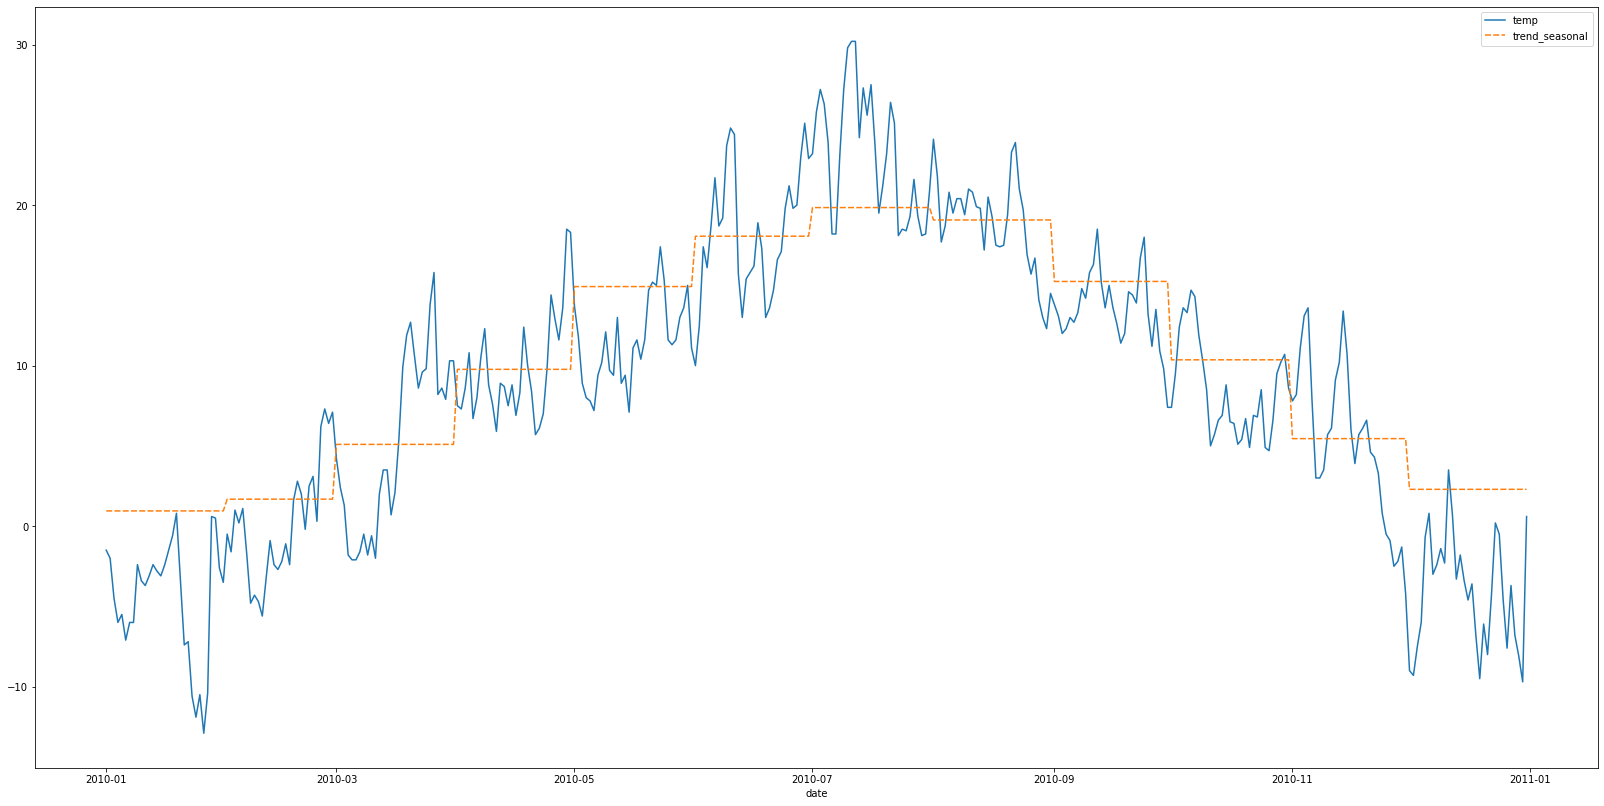

In [9]:
sns.lineplot(data=df_train.loc['2010'][['temp', 'trend_seasonal']])

In [10]:
# extract remainder as a feature
df_train['remainder'] = df_train['temp'] - df_train['trend_seasonal']
df_train.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder
date,,,,,,,,,,,,,,,
1901-01-01,-8.4,0,0,0,0,1,0,0,0,0,0,0,0,-0.779652,-7.620348
1901-01-02,-11.9,1,0,0,0,1,0,0,0,0,0,0,0,-0.779609,-11.120391
1901-01-03,-12.8,2,0,0,0,1,0,0,0,0,0,0,0,-0.779565,-12.020435
1901-01-04,-11.6,3,0,0,0,1,0,0,0,0,0,0,0,-0.779522,-10.820478
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.779478,-9.220522


In [11]:
# since remainder appears to be a stationary time series with values at different time instants that seem correlated
# we introduced a lag feature of the remainder
# we add it now to our model because we want better predictions for the main target passengers

df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)
df_train['lag4'] = df_train['remainder'].shift(4)

df_train.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4
date,,,,,,,,,,,,,,,,,,,
1901-01-01,-8.4,0,0,0,0,1,0,0,0,0,0,0,0,-0.779652,-7.620348,NaN,NaN,NaN,NaN
1901-01-02,-11.9,1,0,0,0,1,0,0,0,0,0,0,0,-0.779609,-11.120391,-7.620348,NaN,NaN,NaN
1901-01-03,-12.8,2,0,0,0,1,0,0,0,0,0,0,0,-0.779565,-12.020435,-11.120391,-7.620348,NaN,NaN
1901-01-04,-11.6,3,0,0,0,1,0,0,0,0,0,0,0,-0.779522,-10.820478,-12.020435,-11.120391,-7.620348,NaN
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.779478,-9.220522,-10.820478,-12.020435,-11.120391,-7.620348


In [12]:
# drop na
df_train.dropna(inplace=True)
df_train.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4
date,,,,,,,,,,,,,,,,,,,
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.779478,-9.220522,-10.820478,-12.020435,-11.120391,-7.620348
1901-01-06,-11.9,5,0,0,0,1,0,0,0,0,0,0,0,-0.779435,-11.120565,-9.220522,-10.820478,-12.020435,-11.120391
1901-01-07,-6.6,6,0,0,0,1,0,0,0,0,0,0,0,-0.779391,-5.820609,-11.120565,-9.220522,-10.820478,-12.020435
1901-01-08,-5.2,7,0,0,0,1,0,0,0,0,0,0,0,-0.779347,-4.420653,-5.820609,-11.120565,-9.220522,-10.820478
1901-01-09,-3.6,8,0,0,0,1,0,0,0,0,0,0,0,-0.779304,-2.820696,-4.420653,-5.820609,-11.120565,-9.220522


In [13]:
# define our new X and y and instantiate model
X = df_train.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
y = df_train['temp']

m_full = LinearRegression()
X.head()

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3,lag4
date,,,,,,,,,,,,,,,,
1901-01-05,4,0,0,0,1,0,0,0,0,0,0,0,-10.820478,-12.020435,-11.120391,-7.620348
1901-01-06,5,0,0,0,1,0,0,0,0,0,0,0,-9.220522,-10.820478,-12.020435,-11.120391
1901-01-07,6,0,0,0,1,0,0,0,0,0,0,0,-11.120565,-9.220522,-10.820478,-12.020435
1901-01-08,7,0,0,0,1,0,0,0,0,0,0,0,-5.820609,-11.120565,-9.220522,-10.820478
1901-01-09,8,0,0,0,1,0,0,0,0,0,0,0,-4.420653,-5.820609,-11.120565,-9.220522


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43265 entries, 1901-01-05 to 2019-12-31
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestep   43265 non-null  int64  
 1   August     43265 non-null  uint8  
 2   December   43265 non-null  uint8  
 3   February   43265 non-null  uint8  
 4   January    43265 non-null  uint8  
 5   July       43265 non-null  uint8  
 6   June       43265 non-null  uint8  
 7   March      43265 non-null  uint8  
 8   May        43265 non-null  uint8  
 9   November   43265 non-null  uint8  
 10  October    43265 non-null  uint8  
 11  September  43265 non-null  uint8  
 12  lag1       43265 non-null  float64
 13  lag2       43265 non-null  float64
 14  lag3       43265 non-null  float64
 15  lag4       43265 non-null  float64
dtypes: float64(4), int64(1), uint8(11)
memory usage: 2.4 MB


In [15]:
# train model and add predictions on training data
m_full.fit(X, y)

df_train['predictions_full'] = m_full.predict(X)
df_train.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.779478,-9.220522,-10.820478,-12.020435,-11.120391,-7.620348,-9.084961
1901-01-06,-11.9,5,0,0,0,1,0,0,0,0,0,0,0,-0.779435,-11.120565,-9.220522,-10.820478,-12.020435,-11.120391,-7.965444
1901-01-07,-6.6,6,0,0,0,1,0,0,0,0,0,0,0,-0.779391,-5.820609,-11.120565,-9.220522,-10.820478,-12.020435,-9.932266
1901-01-08,-5.2,7,0,0,0,1,0,0,0,0,0,0,0,-0.779347,-4.420653,-5.820609,-11.120565,-9.220522,-10.820478,-4.667704
1901-01-09,-3.6,8,0,0,0,1,0,0,0,0,0,0,0,-0.779304,-2.820696,-4.420653,-5.820609,-11.120565,-9.220522,-4.455113


<AxesSubplot:xlabel='date'>

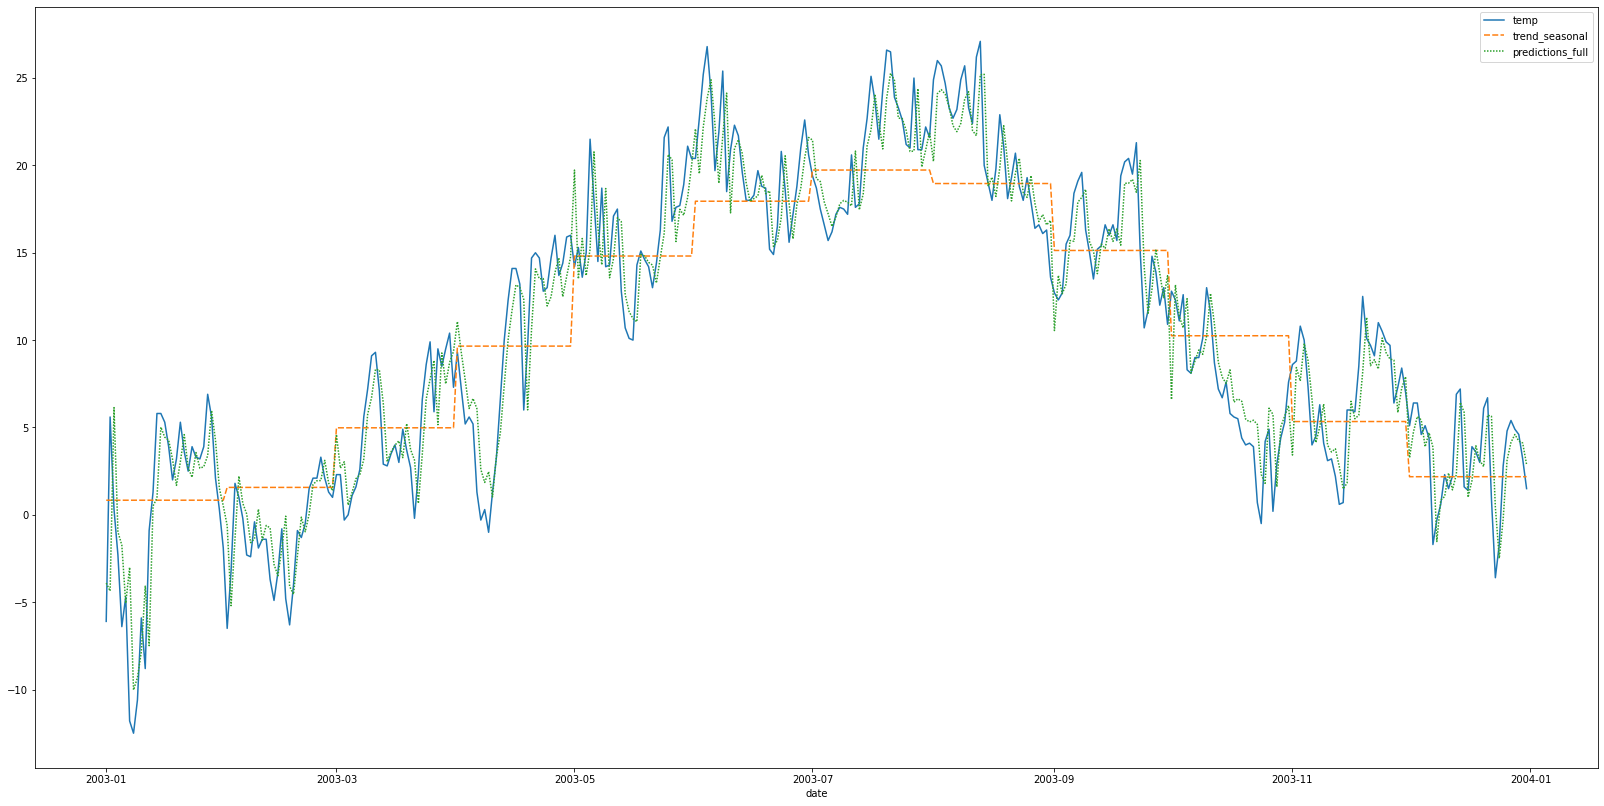

In [16]:
sns.lineplot(data=df_train.loc['2003'][['temp', 'trend_seasonal', 'predictions_full']])

In [17]:
# extracting full model coefficients after the training
pd.DataFrame(m_full.coef_.reshape(1, 16), columns=X.columns)

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3,lag4
0,0.000044,9.250409,-7.467008,-8.031801,-8.785474,10.068084,8.256239,-4.646447,5.149162,-4.304522,0.578181,5.456117,0.906554,-0.18466,0.055333,0.017024


In [18]:
# Create a TimeSeriesSplit object
# instanciate the class and give the k as input
ts_split = TimeSeriesSplit(n_splits=5)
time_cv = ts_split.split(X, y)  # this is a python generator

In [19]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(
        i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(
        i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))

The training data for iteration #1 are the observations steps  = [   0    1    2 ... 7212 7213 7214]
size of training data = 7215
The validation data for iteration #1 are the observations steps = [ 7215  7216  7217 ... 14422 14423 14424]
size of validation data = 7210
The training data for iteration #2 are the observations steps  = [    0     1     2 ... 14422 14423 14424]
size of training data = 14425
The validation data for iteration #2 are the observations steps = [14425 14426 14427 ... 21632 21633 21634]
size of validation data = 7210
The training data for iteration #3 are the observations steps  = [    0     1     2 ... 21632 21633 21634]
size of training data = 21635
The validation data for iteration #3 are the observations steps = [21635 21636 21637 ... 28842 28843 28844]
size of validation data = 7210
The training data for iteration #4 are the observations steps  = [    0     1     2 ... 28842 28843 28844]
size of training data = 28845
The validation data for iteration #4 are t

In [20]:
# cross validate model and read scores
time_cv = ts_split.split(X, y)

estimator = LinearRegression()  # instanciate

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv)

print(r_squared_scores)
print(r_squared_scores.mean())

[0.90584136 0.91645629 0.90682363 0.90239795 0.91705173]
0.9097141936377678


In [21]:
df_test = pd.read_csv("test_data.csv", parse_dates=True, index_col='date')

print(df_test.head())
print(df_test.shape)

            temp
date            
2020-01-01   1.7
2020-01-02   0.5
2020-01-03   4.5
2020-01-04   3.9
2020-01-05   1.2
(366, 1)


In [22]:
df_train.tail()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2019-12-27,2.8,43264,0,1,0,0,0,0,0,0,0,0,0,2.436649,0.363351,2.163394,2.763438,3.563482,4.163525,4.171076
2019-12-28,0.8,43265,0,1,0,0,0,0,0,0,0,0,0,2.436693,-1.636693,0.363351,2.163394,2.763438,3.563482,2.595603
2019-12-29,-0.4,43266,0,1,0,0,0,0,0,0,0,0,0,2.436736,-2.836736,-1.636693,0.363351,2.163394,2.763438,1.068073
2019-12-30,4.7,43267,0,1,0,0,0,0,0,0,0,0,0,2.436780,2.263220,-2.836736,-1.636693,0.363351,2.163394,0.239723
2019-12-31,5.7,43268,0,1,0,0,0,0,0,0,0,0,0,2.436824,3.263176,2.263220,-2.836736,-1.636693,0.363351,4.943439


In [23]:
# add time step
last_train_timestep = df_train['timestep'].max()

df_test['timestep'] = list(
    range(last_train_timestep + 1, len(df_test) + last_train_timestep + 1))
df_test.head()


,temp,timestep
date,,
2020-01-01,1.7,43269
2020-01-02,0.5,43270
2020-01-03,4.5,43271
2020-01-04,3.9,43272
2020-01-05,1.2,43273


In [24]:
# we have to apply the same steps we applied to our train data
df_test['month'] = df_test.index.month_name()

df_test = pd.get_dummies(df_test, prefix='', prefix_sep='', drop_first=True)

df_test.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,
2020-01-01,1.7,43269,0,0,0,1,0,0,0,0,0,0,0
2020-01-02,0.5,43270,0,0,0,1,0,0,0,0,0,0,0
2020-01-03,4.5,43271,0,0,0,1,0,0,0,0,0,0,0
2020-01-04,3.9,43272,0,0,0,1,0,0,0,0,0,0,0
2020-01-05,1.2,43273,0,0,0,1,0,0,0,0,0,0,0


In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       366 non-null    float64
 1   timestep   366 non-null    int64  
 2   August     366 non-null    uint8  
 3   December   366 non-null    uint8  
 4   February   366 non-null    uint8  
 5   January    366 non-null    uint8  
 6   July       366 non-null    uint8  
 7   June       366 non-null    uint8  
 8   March      366 non-null    uint8  
 9   May        366 non-null    uint8  
 10  November   366 non-null    uint8  
 11  October    366 non-null    uint8  
 12  September  366 non-null    uint8  
dtypes: float64(1), int64(1), uint8(11)
memory usage: 12.5 KB


In [26]:
X_test = df_test.drop('temp', axis=1)

df_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)

df_test.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,
2020-01-01,1.7,43269,0,0,0,1,0,0,0,0,0,0,0,1.106230
2020-01-02,0.5,43270,0,0,0,1,0,0,0,0,0,0,0,1.106273
2020-01-03,4.5,43271,0,0,0,1,0,0,0,0,0,0,0,1.106317
2020-01-04,3.9,43272,0,0,0,1,0,0,0,0,0,0,0,1.106360
2020-01-05,1.2,43273,0,0,0,1,0,0,0,0,0,0,0,1.106404


<AxesSubplot:xlabel='date'>

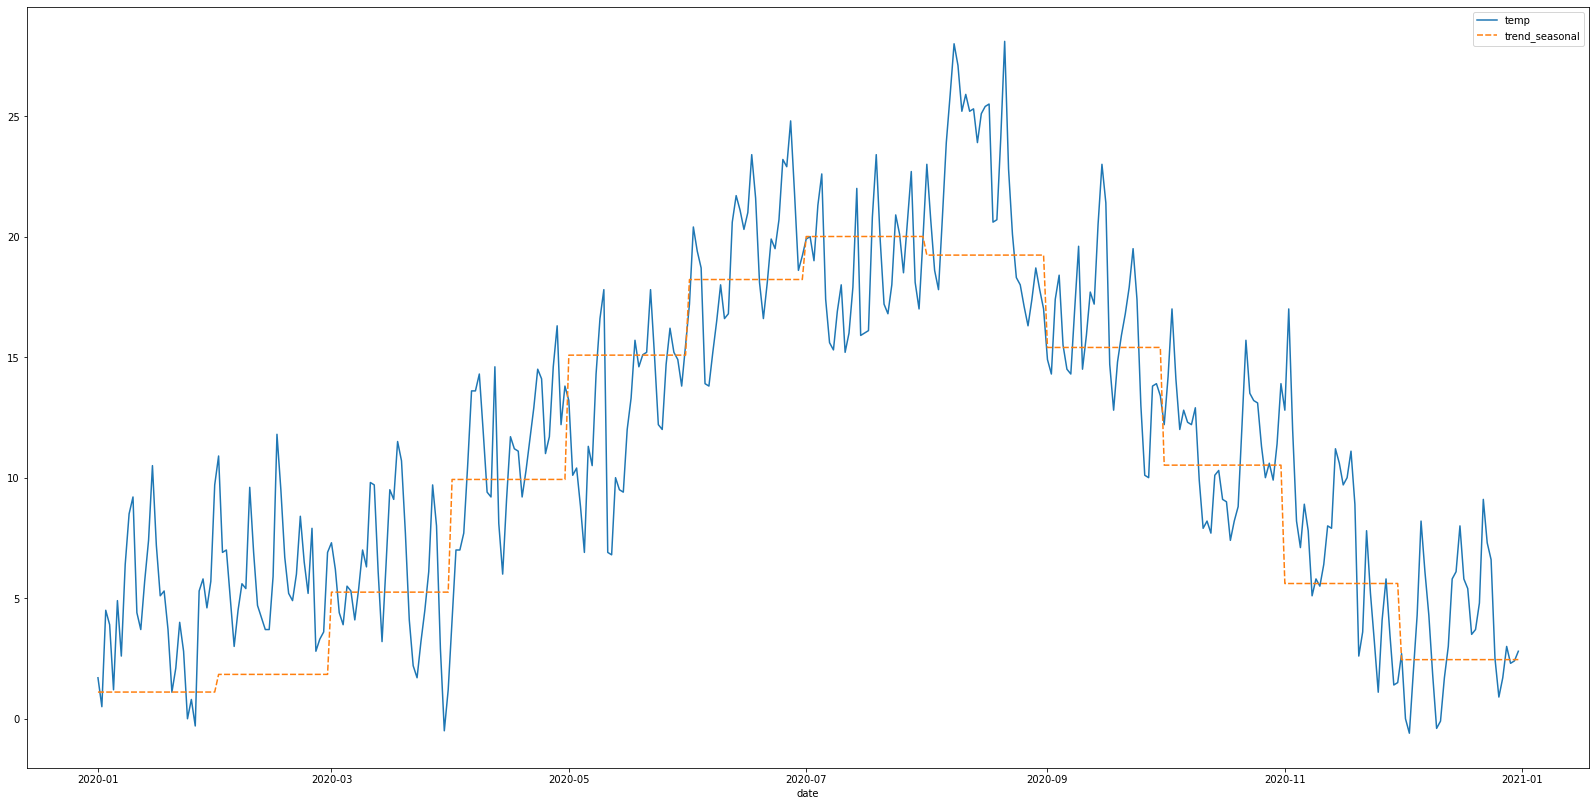

In [27]:
# plot

sns.lineplot(data=df_test[['temp', 'trend_seasonal']])

In [29]:
df_test['remainder'] = df_test['temp'] - df_test['trend_seasonal']

# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test['lag4'] = df_test['remainder'].shift(4)

df_test.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4
date,,,,,,,,,,,,,,,,,,,
2020-01-01,1.7,43269,0,0,0,1,0,0,0,0,0,0,0,1.106230,0.593770,NaN,NaN,NaN,NaN
2020-01-02,0.5,43270,0,0,0,1,0,0,0,0,0,0,0,1.106273,-0.606273,0.593770,NaN,NaN,NaN
2020-01-03,4.5,43271,0,0,0,1,0,0,0,0,0,0,0,1.106317,3.393683,-0.606273,0.593770,NaN,NaN
2020-01-04,3.9,43272,0,0,0,1,0,0,0,0,0,0,0,1.106360,2.793640,3.393683,-0.606273,0.593770,NaN
2020-01-05,1.2,43273,0,0,0,1,0,0,0,0,0,0,0,1.106404,0.093596,2.793640,3.393683,-0.606273,0.59377


In [30]:
df_train.tail()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2019-12-27,2.8,43264,0,1,0,0,0,0,0,0,0,0,0,2.436649,0.363351,2.163394,2.763438,3.563482,4.163525,4.171076
2019-12-28,0.8,43265,0,1,0,0,0,0,0,0,0,0,0,2.436693,-1.636693,0.363351,2.163394,2.763438,3.563482,2.595603
2019-12-29,-0.4,43266,0,1,0,0,0,0,0,0,0,0,0,2.436736,-2.836736,-1.636693,0.363351,2.163394,2.763438,1.068073
2019-12-30,4.7,43267,0,1,0,0,0,0,0,0,0,0,0,2.436780,2.263220,-2.836736,-1.636693,0.363351,2.163394,0.239723
2019-12-31,5.7,43268,0,1,0,0,0,0,0,0,0,0,0,2.436824,3.263176,2.263220,-2.836736,-1.636693,0.363351,4.943439


In [32]:
# must fill NaN
df_test.loc['2020-01-01', 'lag1'] = df_train.loc['2019-12-28', 'remainder']
df_test.loc['2020-01-02', 'lag2'] = df_train.loc['2019-12-28', 'remainder']
df_test.loc['2020-01-03', 'lag3'] = df_train.loc['2019-12-28', 'remainder']
df_test.loc['2020-01-04', 'lag4'] = df_train.loc['2019-12-28', 'remainder']
df_test.loc['2020-01-01', 'lag2'] = df_train.loc['2019-12-29', 'remainder']
df_test.loc['2020-01-02', 'lag3'] = df_train.loc['2019-12-29', 'remainder']
df_test.loc['2020-01-03', 'lag4'] = df_train.loc['2019-12-29', 'remainder']
df_test.loc['2020-01-01', 'lag3'] = df_train.loc['2019-12-30', 'remainder']
df_test.loc['2020-01-02', 'lag4'] = df_train.loc['2019-12-30', 'remainder']
df_test.loc['2020-01-01', 'lag4'] = df_train.loc['2019-12-31', 'remainder']

df_test.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4
date,,,,,,,,,,,,,,,,,,,
2020-01-01,1.7,43269,0,0,0,1,0,0,0,0,0,0,0,1.106230,0.593770,-1.636693,-2.836736,2.263220,3.263176
2020-01-02,0.5,43270,0,0,0,1,0,0,0,0,0,0,0,1.106273,-0.606273,0.593770,-1.636693,-2.836736,2.263220
2020-01-03,4.5,43271,0,0,0,1,0,0,0,0,0,0,0,1.106317,3.393683,-0.606273,0.593770,-1.636693,-2.836736
2020-01-04,3.9,43272,0,0,0,1,0,0,0,0,0,0,0,1.106360,2.793640,3.393683,-0.606273,0.593770,-1.636693
2020-01-05,1.2,43273,0,0,0,1,0,0,0,0,0,0,0,1.106404,0.093596,2.793640,3.393683,-0.606273,0.593770


In [33]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            366 non-null    float64
 1   timestep        366 non-null    int64  
 2   August          366 non-null    uint8  
 3   December        366 non-null    uint8  
 4   February        366 non-null    uint8  
 5   January         366 non-null    uint8  
 6   July            366 non-null    uint8  
 7   June            366 non-null    uint8  
 8   March           366 non-null    uint8  
 9   May             366 non-null    uint8  
 10  November        366 non-null    uint8  
 11  October         366 non-null    uint8  
 12  September       366 non-null    uint8  
 13  trend_seasonal  366 non-null    float64
 14  remainder       366 non-null    float64
 15  lag1            366 non-null    float64
 16  lag2            366 non-null    float64
 17  lag3            

In [34]:
# make full model predictions
X_test = df_test.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
# Create the predictions
df_test['predictions_full'] = m_full.predict(X_test)

df_test.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.7,43269,0,0,0,1,0,0,0,0,0,0,0,1.106230,0.593770,-1.636693,-2.836736,2.263220,3.263176,0.354698
2020-01-02,0.5,43270,0,0,0,1,0,0,0,0,0,0,0,1.106273,-0.606273,0.593770,-1.636693,-2.836736,2.263220,1.855956
2020-01-03,4.5,43271,0,0,0,1,0,0,0,0,0,0,0,1.106317,3.393683,-0.606273,0.593770,-1.636693,-2.836736,0.335796
2020-01-04,3.9,43272,0,0,0,1,0,0,0,0,0,0,0,1.106360,2.793640,3.393683,-0.606273,0.593770,-1.636693,4.327465
2020-01-05,1.2,43273,0,0,0,1,0,0,0,0,0,0,0,1.106404,0.093596,2.793640,3.393683,-0.606273,0.593770,3.016474


<AxesSubplot:xlabel='date'>

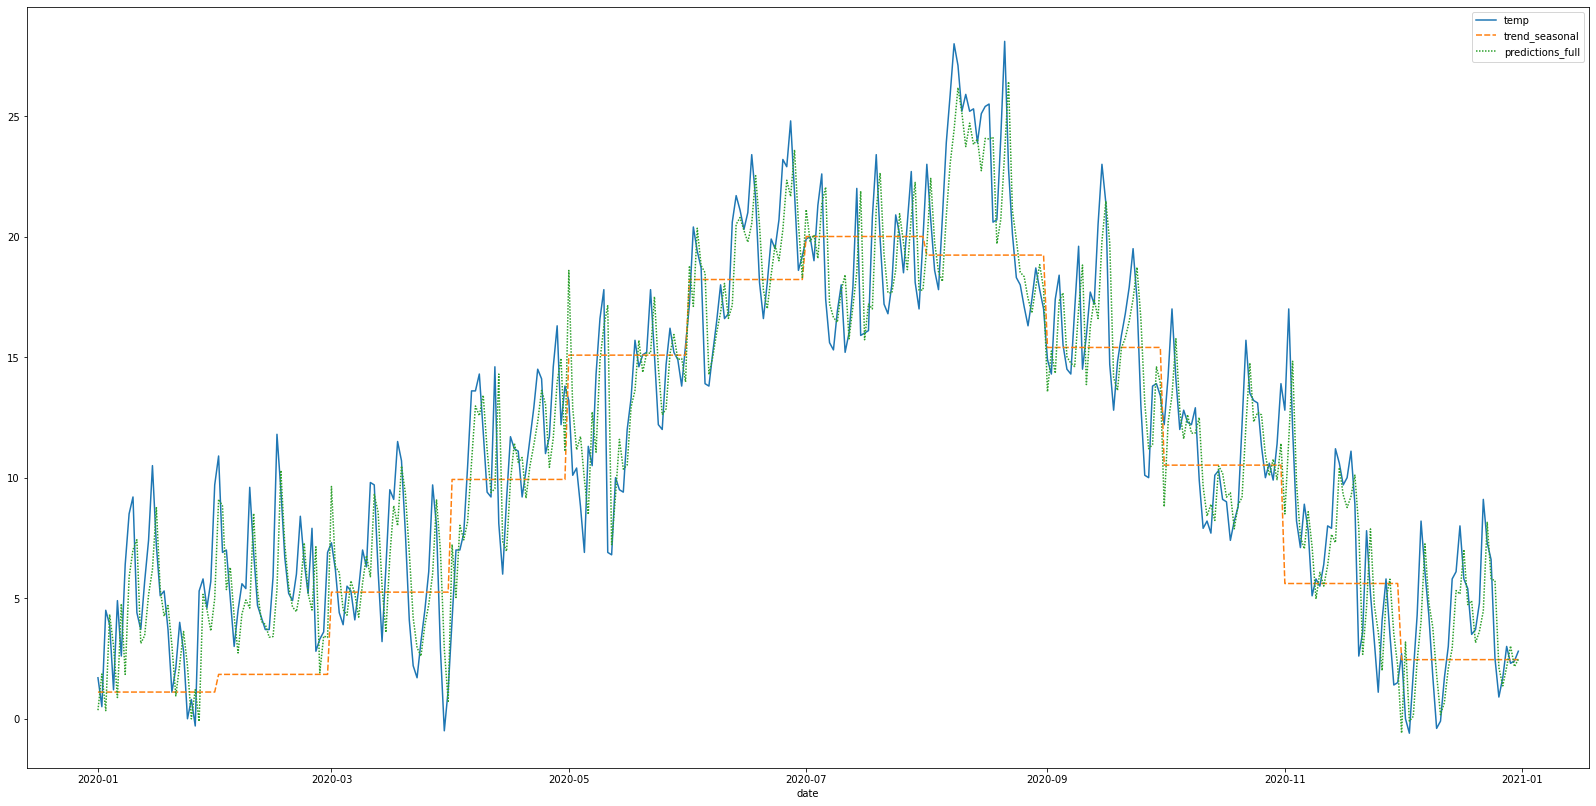

In [35]:
sns.lineplot(data=df_test[['temp', 'trend_seasonal', 'predictions_full']])


In [36]:
# let's check R squared score

# the score of the trend and season. model
print(r2_score(df_test['temp'], df_test['trend_seasonal']))

# score of the full model
print(r2_score(df_test['temp'], df_test['predictions_full']))


0.7181602203746938
0.8911091232758267


In [37]:
# join test and train data together
df_combined = df_train.append(df_test)
df_combined.tail()


,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2020-12-27,1.7,43630,0,1,0,0,0,0,0,0,0,0,0,2.452601,-0.752601,-1.552558,0.047486,4.147529,4.847573,1.363795
2020-12-28,3.0,43631,0,1,0,0,0,0,0,0,0,0,0,2.452645,0.547355,-0.752601,-1.552558,0.047486,4.147529,2.145720
2020-12-29,2.3,43632,0,1,0,0,0,0,0,0,0,0,0,2.452688,-0.152688,0.547355,-0.752601,-1.552558,0.047486,3.018188
2020-12-30,2.4,43633,0,1,0,0,0,0,0,0,0,0,0,2.452732,-0.052732,-0.152688,0.547355,-0.752601,-1.552558,2.160578
2020-12-31,2.8,43634,0,1,0,0,0,0,0,0,0,0,0,2.452776,0.347224,-0.052732,-0.152688,0.547355,-0.752601,2.466057


In [38]:
df_combined.head()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
1901-01-05,-10.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.779478,-9.220522,-10.820478,-12.020435,-11.120391,-7.620348,-9.084961
1901-01-06,-11.9,5,0,0,0,1,0,0,0,0,0,0,0,-0.779435,-11.120565,-9.220522,-10.820478,-12.020435,-11.120391,-7.965444
1901-01-07,-6.6,6,0,0,0,1,0,0,0,0,0,0,0,-0.779391,-5.820609,-11.120565,-9.220522,-10.820478,-12.020435,-9.932266
1901-01-08,-5.2,7,0,0,0,1,0,0,0,0,0,0,0,-0.779347,-4.420653,-5.820609,-11.120565,-9.220522,-10.820478,-4.667704
1901-01-09,-3.6,8,0,0,0,1,0,0,0,0,0,0,0,-0.779304,-2.820696,-4.420653,-5.820609,-11.120565,-9.220522,-4.455113


In [39]:
df_combined.to_csv('combined_data.csv')

In [40]:
df_combined.isna().sum()

temp                0
timestep            0
August              0
December            0
February            0
January             0
July                0
June                0
March               0
May                 0
November            0
October             0
September           0
trend_seasonal      0
remainder           0
lag1                0
lag2                0
lag3                0
lag4                0
predictions_full    0
dtype: int64

In [41]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(
    columns=['temp', 'trend_seasonal', 'remainder', 'predictions_full'])
y_combined = df_combined['temp']

m_full_combined = LinearRegression()
m_full_combined.fit(X_combined, y_combined)

LinearRegression()

In [42]:
df_combined.index.max()

Timestamp('2020-12-31 00:00:00')

In [43]:
df_combined.tail()

,temp,timestep,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,lag4,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2020-12-27,1.7,43630,0,1,0,0,0,0,0,0,0,0,0,2.452601,-0.752601,-1.552558,0.047486,4.147529,4.847573,1.363795
2020-12-28,3.0,43631,0,1,0,0,0,0,0,0,0,0,0,2.452645,0.547355,-0.752601,-1.552558,0.047486,4.147529,2.145720
2020-12-29,2.3,43632,0,1,0,0,0,0,0,0,0,0,0,2.452688,-0.152688,0.547355,-0.752601,-1.552558,0.047486,3.018188
2020-12-30,2.4,43633,0,1,0,0,0,0,0,0,0,0,0,2.452732,-0.052732,-0.152688,0.547355,-0.752601,-1.552558,2.160578
2020-12-31,2.8,43634,0,1,0,0,0,0,0,0,0,0,0,2.452776,0.347224,-0.052732,-0.152688,0.547355,-0.752601,2.466057


In [45]:
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43631 entries, 1901-01-05 to 2020-12-31
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestep   43631 non-null  int64  
 1   August     43631 non-null  uint8  
 2   December   43631 non-null  uint8  
 3   February   43631 non-null  uint8  
 4   January    43631 non-null  uint8  
 5   July       43631 non-null  uint8  
 6   June       43631 non-null  uint8  
 7   March      43631 non-null  uint8  
 8   May        43631 non-null  uint8  
 9   November   43631 non-null  uint8  
 10  October    43631 non-null  uint8  
 11  September  43631 non-null  uint8  
 12  lag1       43631 non-null  float64
 13  lag2       43631 non-null  float64
 14  lag3       43631 non-null  float64
 15  lag4       43631 non-null  float64
dtypes: float64(4), int64(1), uint8(11)
memory usage: 3.5 MB


In [44]:
# so we need to generate features for the time point 2021-01-01
X_future = []

timestep = df_combined['timestep'].max() + 1
months = [0]*3 + [1] + [0]*7  # dummy code for Jan
lag1 = df_combined.loc['2020-12-28','remainder']  # taking the last remainder
lag2 = df_combined.loc['2020-12-29','remainder']  # taking the last remainder
lag3 = df_combined.loc['2020-12-30','remainder']  # taking the last remainder
lag4 = df_combined.loc['2020-12-31','remainder']  # taking the last remainder
print(timestep, months, lag1,lag2,lag3,lag4)


43635 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 0.5473550896145358 -0.15268849544613294 -0.05273208050680189 0.347224334432529


In [46]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future.append(lag4)

X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

In [48]:
X_future.head()

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3,lag4
0,43635,0,0,0,1,0,0,0,0,0,0,0,0.547355,-0.152688,-0.052732,0.347224


In [52]:
print(f"Prediction for 2021-01-01 is {m_full_combined.predict(X_future)[0]}")


Prediction for 2021-01-01 is 1.6911482875331663
